# Project: Time series predictor with zero prescriptor ESP project
Description: Similar setup to Covid NPI project  
12/18/25: switch to package preprocessors

In [1]:
# import packages
import numpy as np
import pandas as pd
import torch
from typing import List, Dict, Any, Optional, Tuple, Sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# set working directory so we can load data correctly (all functions at this point are not put into modules yet)
import os
os.chdir('..')
os.getcwd()

'/Users/964505/CT/ct_research'

## Config

In [3]:
# ===================== CONFIG =====================
CONFIG = {
    "time": {
        "granularity": "week",
        "week_freq": "W-MON",
        "lookback_weeks": 12,
        "lookahead_weeks": 6,
        "agg": "mean",
        "missing_code": "00",
    },
    "features": {
        # pair-encoding is always used (present, 1-x)
        "covariates": [
            "week_index",
            "weeks_since_last_active",
            "n_sessions_week",
            "n_domains_week",
            "week_of_year",
        ]
    },
    "model": {
        "d_hidden": 128,
        "enc_layers": 1,
        "trunk_hidden": 128,
        "dropout": 0.10,
        "user_embed_dim": 32,
        "lowrank_r": 0,
    },
    "train": {
        "batch_size": 128,
        "epochs": 6,
        "lr": 2e-3,
        "weight_decay": 1e-4,
        "grad_clip": 1.0,
        "drop_no_target": True,
        "val_frac": 0.15,
        "train_frac": 0.70,
        "seed": 42,
    },
    "targets": {
        "outcome": "global",
    }
}
# ==============================================================

## General Helper Functions

In [4]:
def global_score(y_vec: np.ndarray, mask_vec: Optional[np.ndarray] = None) -> float:
    """
    y_vec: (K,) per-domain scores in [0,1]
    mask_vec: (K,) optional 1/0 mask of which domains are observed
    """
    if mask_vec is None:
        return float(np.mean(y_vec))
    m = np.asarray(mask_vec, dtype=float)
    s = m.sum()
    return 0.0 if s <= 1e-8 else float((y_vec * m).sum() / s)

In [5]:
def advance_weekly_covariates(last_x: np.ndarray) -> np.ndarray:
    """
    last_x: (D_x,) ordered as [week_index, weeks_since_last_active, n_sessions_week, n_domains_week, week_of_year]
    MVP policy: keep volume/breadth fixed; increment week_index + week_of_year; update gap accordingly.
    """
    week_index, gap, nsess, ndoms, week_of_year = last_x.tolist()
    week_index = float(week_index) + 1.0
    week_of_year = int(week_of_year) + 1
    if week_of_year > 53: week_of_year = 1
    gap = 0.0 if nsess > 0 else float(gap) + 1.0
    return np.array([week_index, gap, nsess, ndoms, float(week_of_year)], dtype=np.float32)

In [6]:
@dataclass
class RunConfig:
    window: int = 32
    horizon: int = 1
    outcome: str = "global"     # or "per_domain"
    lookahead_days: int = 6 * 7
    seed: int = 42

In [7]:
def get_users_with_min_viable_weeks(
    M_target: np.ndarray,
    meta: dict,
    min_weeks: int = 4,
    verbose: bool = True,
):
    """
    Return a list of user indices who have at least `min_weeks` viable weeks.
    
    A 'viable week' is defined as a week with at least one observed domain score.
    
    Parameters
    ----------
    M_target : np.ndarray
        Array of shape [U, T_max, K], mask of observed scores.
    meta : dict
        Metadata dictionary from encoder containing "weeks_per_user".
    min_weeks : int
        Minimum number of viable weeks required.
    verbose : bool
        Whether to print summary information.

    Returns
    -------
    List[int]
        User indices that satisfy the requirement.
    """
    U, T_max, K = M_target.shape
    viable_users = []
    viable_counts = []

    for u in range(U):
        T_u = len(meta["weeks_per_user"][u])
        M_u = M_target[u, :T_u]             # slice valid weeks only
        weekly_obs = (M_u.sum(axis=1) > 0)  # boolean: domain observed?
        n_viable = weekly_obs.sum()

        if n_viable >= min_weeks:
            viable_users.append(u)
            viable_counts.append(n_viable)

    if verbose:
        print(f"Users meeting >= {min_weeks} viable weeks: {len(viable_users)} / {U}")
        if len(viable_users) > 0:
            print(f"  Min viable = {min(viable_counts)}, Max viable = {max(viable_counts)}")
            print(f"  Median viable = {np.median(viable_counts):.1f}")
        else:
            print("  No users meet the criterion.")

    return viable_users

In [8]:
def get_user_indices_from_passing_users(meta, passing_users: set[int]) -> list[int]:
    """
    Given meta['users'] and a set of patient_ids (passing_users),
    return user indices that correspond to those patients.
    """
    idxs = [
        u_idx
        for u_idx, pid in enumerate(meta["users"])
        if pid in passing_users
    ]
    return idxs

## Load data

In [9]:
raw_data_df = pd.read_csv('data/raw/predictor_data_20250529.csv')
raw_data_df.head()

/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_14842/3211444471.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_df = pd.read_csv('data/raw/predictor_data_20250529.csv')


,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
0,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
1,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
2,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
3,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
4,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"


In [10]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80506846 entries, 0 to 80506845
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   patient_id     int64 
 2   start_time     object
 3   task_type_id   int64 
 4   task_level     int64 
 5   domain_ids     object
 6   domain_scores  object
dtypes: int64(4), object(3)
memory usage: 4.2+ GB


## Data preprocessing

In [11]:
from ct.data.consolidating import HistoryEncoder
from ct.viz.data import plot_random_patient_domain_avg

Preprocess data

In [12]:
encoder = HistoryEncoder(raw_data_df)
weekly_df = encoder.transform()

In [13]:
weekly_df.head()

domain_1_freq  domain_2_freq  domain_3_freq  \
patient_id week_number                                                
2171       0                        5              0              0   
           1                        0              0              0   
           2                        5              0              0   
           3                       10              0              0   
           4                       20              0              0   

                        domain_4_freq  domain_5_freq  domain_6_freq  \
patient_id week_number                                                
2171       0                        5              5              5   
           1                        0              0              0   
           2                        5              5              5   
           3                       10             10             10   
           4                       20             20             20   

                        domain_7_freq  domain_8_freq  domain_9_freq  \
patient_id week_number                                                
2171       0                        5              0              5   
           1                        0              0              0   
           2                        5              0              5   
           3                       10              0             10   
           4                       20              0             20   

                        domain_10_freq  ...  domain_5_inv  domain_6_inv  \
patient_id week_number                  ...                               
2171       0                         0  ...        0.7000         0.674   
           1                         0  ...        0.7000         0.674   
           2                         5  ...        0.7100         0.705   
           3                        10  ...        0.7250         0.737   
           4                        20  ...        0.7475         0.721   

                        domain_7_inv  domain_8_inv domain_9_inv  \
patient_id week_number                                            
2171       0                   0.790           0.0        0.370   
           1                   0.790           0.0        0.370   
           2                   0.820           0.0        0.460   
           3                   0.850           0.0        0.550   
           4                   0.835           0.0        0.505   

                        domain_10_inv  domain_11_inv  domain_12_inv  \
patient_id week_number                                                
2171       0                    0.000            0.0        0.00000   
           1                    0.000            0.0        0.00000   
           2                    0.379            0.0        0.48600   
           3                    0.379            0.0        0.47800   
           4                    0.232            0.0        0.46575   

                        domain_13_inv  domain_14_inv  
patient_id week_number                                
2171       0                    0.000            0.0  
           1                    0.000            0.0  
           2                    0.206            0.0  
           3                    0.224            0.0  
           4                    0.242            0.0  

[5 rows x 43 columns]

In [14]:
weekly_df.describe()

,domain_1_freq,domain_2_freq,domain_3_freq,domain_4_freq,domain_5_freq,domain_6_freq,domain_7_freq,domain_8_freq,domain_9_freq,domain_10_freq,...,domain_5_inv,domain_6_inv,domain_7_inv,domain_8_inv,domain_9_inv,domain_10_inv,domain_11_inv,domain_12_inv,domain_13_inv,domain_14_inv
count,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,...,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000
mean,16.013842,7.446415,11.043027,15.313006,19.114266,10.678032,5.505102,2.965343,8.518805,23.710839,...,0.655286,0.381779,0.228614,0.189140,0.398550,0.399089,0.118117,0.534350,0.363577,0.209011
std,66.437980,35.379972,46.786699,51.349464,64.319447,53.032810,32.197931,20.929224,35.986673,83.935611,...,0.317380,0.354823,0.321833,0.314508,0.363505,0.278469,0.227269,0.298551,0.271753,0.271464
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.516000,0.000000,0.000000,0.000000,0.000000,0.161000,0.000000,0.364000,0.108000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.764500,0.301667,0.000000,0.000000,0.390000,0.423000,0.000000,0.622000,0.364000,0.027000
75%,8.000000,0.000000,3.000000,10.000000,14.000000,0.000000,0.000000,0.000000,0.000000,15.000000,...,0.903000,0.720000,0.500000,0.283200,0.750000,0.600000,0.160000,0.750000,0.569667,0.333000
max,4152.000000,4080.000000,5500.000000,3720.000000,6760.000000,6912.000000,5016.000000,2328.000000,4428.000000,6744.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# -------------------------
# 0) Column setup
# -------------------------
K = 14
avg_cols  = [f"domain_{i}_avg"  for i in range(1, K+1)]
inv_cols  = [f"domain_{i}_inv"  for i in range(1, K+1)]
freq_cols = [f"domain_{i}_freq" for i in range(1, K+1)]
obs_cols  = [f"domain_{i}_obs"  for i in range(1, K+1)]

Filtering

In [16]:
from ct.data.filtering import densify_week_grid_ffill_scores, filter_patients_allow_gaps_with_cap

In [17]:
dense_df = densify_week_grid_ffill_scores(
    weekly_df,
    freq_cols=freq_cols,
    avg_cols=avg_cols,
    inv_cols=inv_cols
)

filtered_weekly_df = filter_patients_allow_gaps_with_cap(
    dense_df,
    obs_cols=obs_cols,
    max_gap_weeks=6,
    lookback_weeks=12,
    min_observed_target_weeks=8,
)

In [18]:
filtered_weekly_df.describe()

,domain_1_freq,domain_2_freq,domain_3_freq,domain_4_freq,domain_5_freq,domain_6_freq,domain_7_freq,domain_8_freq,domain_9_freq,domain_10_freq,...,domain_5_obs,domain_6_obs,domain_7_obs,domain_8_obs,domain_9_obs,domain_10_obs,domain_11_obs,domain_12_obs,domain_13_obs,domain_14_obs
count,569757.000000,569757.000000,569757.000000,569757.000000,569757.000000,569757.000000,569757.000000,569757.000000,569757.000000,569757.000000,...,569757.0,569757.0,569757.0,569757.0,569757.0,569757.0,569757.0,569757.0,569757.0,569757.0
mean,16.637359,8.277316,8.789861,15.331215,19.787690,10.130092,6.062076,3.030813,8.576907,23.553194,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,70.096815,37.450694,43.229614,52.987132,67.289648,53.957367,33.672998,21.731918,36.291748,85.532113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,8.000000,0.000000,0.000000,9.000000,14.000000,0.000000,0.000000,0.000000,0.000000,12.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,4152.000000,4080.000000,5500.000000,3720.000000,6760.000000,6912.000000,5016.000000,2328.000000,4428.000000,6744.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Visualize user trajectory

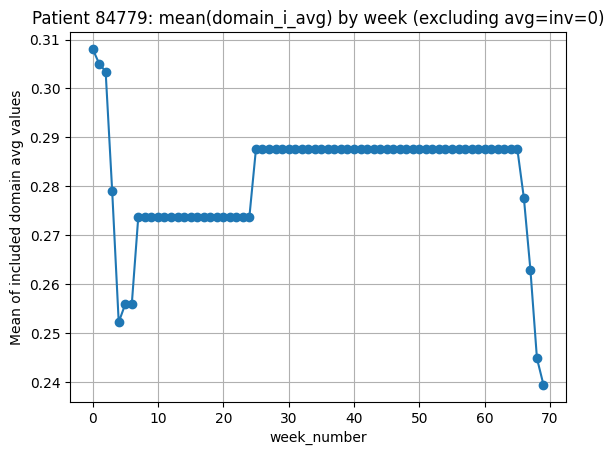

In [19]:
pid, aggregate_weekly_df = plot_random_patient_domain_avg(filtered_weekly_df, seed=42)

In [20]:
print(f"Plotted patient_id: {pid}")

Plotted patient_id: 84779


In [21]:
filtered_weekly_df.columns

Index(['domain_1_freq', 'domain_2_freq', 'domain_3_freq', 'domain_4_freq',
       'domain_5_freq', 'domain_6_freq', 'domain_7_freq', 'domain_8_freq',
       'domain_9_freq', 'domain_10_freq', 'domain_11_freq', 'domain_12_freq',
       'domain_13_freq', 'domain_14_freq', 'week_start_ts', 'domain_1_avg',
       'domain_2_avg', 'domain_3_avg', 'domain_4_avg', 'domain_5_avg',
       'domain_6_avg', 'domain_7_avg', 'domain_8_avg', 'domain_9_avg',
       'domain_10_avg', 'domain_11_avg', 'domain_12_avg', 'domain_13_avg',
       'domain_14_avg', 'domain_1_inv', 'domain_2_inv', 'domain_3_inv',
       'domain_4_inv', 'domain_5_inv', 'domain_6_inv', 'domain_7_inv',
       'domain_8_inv', 'domain_9_inv', 'domain_10_inv', 'domain_11_inv',
       'domain_12_inv', 'domain_13_inv', 'domain_14_inv', 'domain_1_obs',
       'domain_2_obs', 'domain_3_obs', 'domain_4_obs', 'domain_5_obs',
       'domain_6_obs', 'domain_7_obs', 'domain_8_obs', 'domain_9_obs',
       'domain_10_obs', 'domain_11_obs', 'domai

## Data encoding: turn into model input

Define model input data encoder

In [22]:
# -------------------------
# 1) Data split + samples
# -------------------------
def split_patients(df: pd.DataFrame, train=0.7, val=0.15, test=0.15, seed=0):
    assert abs(train + val + test - 1.0) < 1e-6
    patients = df.index.get_level_values(0).unique().to_numpy()
    rng = np.random.default_rng(seed)
    rng.shuffle(patients)

    n = len(patients)
    n_tr = int(round(train * n))
    n_va = int(round(val * n))

    tr = patients[:n_tr]
    va = patients[n_tr:n_tr + n_va]
    te = patients[n_tr + n_va:]
    return tr, va, te


def build_samples_from_df(
    df: pd.DataFrame,
    window: int,
    avg_cols: list[str],
    inv_cols: list[str],
    freq_cols: list[str],
    obs_cols: list[str],
):
    """
    Builds training samples from dense, filtered df.

    Supervised mask m_obs_next uses obs_cols at t+1.
    Stability target y_prev uses avg at t (last week in history).
    """
    df = df.sort_index(level=[0, 1])
    patients = df.index.get_level_values(0).unique().tolist()

    samples = []
    for pid in patients:
        sub = df.xs(pid, level=0).sort_index()
        if len(sub) < window + 1:
            continue

        AVG  = sub[avg_cols].to_numpy(np.float32)    # [T,K]
        INV  = sub[inv_cols].to_numpy(np.float32)    # [T,K]
        FREQ = sub[freq_cols].to_numpy(np.float32)   # [T,K]
        OBS  = sub[obs_cols].to_numpy(np.float32)    # [T,K] 1=real obs, 0=imputed gap

        SEQ = np.concatenate([AVG, INV, FREQ], axis=-1)  # [T,3K]
        T = len(sub)

        for t in range(window - 1, T - 1):
            # history ends at t
            seq_hist = SEQ[t - window + 1: t + 1]   # [W,3K]
            y_next   = AVG[t + 1]                   # [K]
            m_obs    = OBS[t + 1]                   # [K] supervised mask
            y_prev   = AVG[t]                       # [K] for gap-stability loss

            # if nothing observed in target week, skip (avoids empty-gradient samples)
            if m_obs.sum() == 0:
                continue

            samples.append((pid, seq_hist, y_next, m_obs, y_prev))

    return samples


class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, samples, patient_to_index):
        self.samples = samples
        self.patient_to_index = patient_to_index

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        pid, seq_hist, y_next, m_obs, y_prev = self.samples[i]
        return {
            "seq_hist": torch.from_numpy(seq_hist),        # [W,3K]
            "y_next": torch.from_numpy(y_next),            # [K]
            "m_obs_next": torch.from_numpy(m_obs),         # [K]
            "y_prev": torch.from_numpy(y_prev),            # [K]
            "user_idx": torch.tensor(self.patient_to_index[pid], dtype=torch.long),
        }


def make_loaders(df: pd.DataFrame, window=12, batch_size=128, seed=0, num_workers=0):
    tr_p, va_p, te_p = split_patients(df, seed=seed)

    def subdf(pids):
        return df.loc[df.index.get_level_values(0).isin(pids)]

    tr_samples = build_samples_from_df(subdf(tr_p), window=window, avg_cols=avg_cols, inv_cols=inv_cols, freq_cols=freq_cols, obs_cols=obs_cols)
    va_samples = build_samples_from_df(subdf(va_p), window=window, avg_cols=avg_cols, inv_cols=inv_cols, freq_cols=freq_cols, obs_cols=obs_cols)
    te_samples = build_samples_from_df(subdf(te_p), window=window, avg_cols=avg_cols, inv_cols=inv_cols, freq_cols=freq_cols, obs_cols=obs_cols)

    all_p = df.index.get_level_values(0).unique().tolist()
    patient_to_index = {pid: i for i, pid in enumerate(all_p)}

    tr_ds = SeqDataset(tr_samples, patient_to_index)
    va_ds = SeqDataset(va_samples, patient_to_index)
    te_ds = SeqDataset(te_samples, patient_to_index)

    tr_dl = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    va_dl = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    te_dl = DataLoader(te_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return tr_dl, va_dl, te_dl, len(all_p), patient_to_index




build cao map for later

In [23]:
from typing import Dict, List

def build_cao_mapping(K: int = 14) -> Dict[str, List[str]]:
    avg_cols  = [f"domain_{i}_avg"  for i in range(1, K+1)]
    inv_cols  = [f"domain_{i}_inv"  for i in range(1, K+1)]
    freq_cols = [f"domain_{i}_freq" for i in range(1, K+1)]

    return {
        "context":  avg_cols + inv_cols,   # what you condition on (state)
        "actions":  freq_cols,             # interventions (prescriptions)
        "outcomes": avg_cols,              # what predictor outputs/targets
    }

In [24]:
cao_mapping = build_cao_mapping(K=K)

In [25]:
cao_mapping

{'context': ['domain_1_avg',
  'domain_2_avg',
  'domain_3_avg',
  'domain_4_avg',
  'domain_5_avg',
  'domain_6_avg',
  'domain_7_avg',
  'domain_8_avg',
  'domain_9_avg',
  'domain_10_avg',
  'domain_11_avg',
  'domain_12_avg',
  'domain_13_avg',
  'domain_14_avg',
  'domain_1_inv',
  'domain_2_inv',
  'domain_3_inv',
  'domain_4_inv',
  'domain_5_inv',
  'domain_6_inv',
  'domain_7_inv',
  'domain_8_inv',
  'domain_9_inv',
  'domain_10_inv',
  'domain_11_inv',
  'domain_12_inv',
  'domain_13_inv',
  'domain_14_inv'],
 'actions': ['domain_1_freq',
  'domain_2_freq',
  'domain_3_freq',
  'domain_4_freq',
  'domain_5_freq',
  'domain_6_freq',
  'domain_7_freq',
  'domain_8_freq',
  'domain_9_freq',
  'domain_10_freq',
  'domain_11_freq',
  'domain_12_freq',
  'domain_13_freq',
  'domain_14_freq'],
 'outcomes': ['domain_1_avg',
  'domain_2_avg',
  'domain_3_avg',
  'domain_4_avg',
  'domain_5_avg',
  'domain_6_avg',
  'domain_7_avg',
  'domain_8_avg',
  'domain_9_avg',
  'domain_10_avg'

## Predictor

Define predictor

In [26]:
# -------------------------
# 2) Model: GRU -> MLP -> avg prediction
# -------------------------
class TemporalEncoderGRU(nn.Module):
    def __init__(self, d_in, d_hidden=128, num_layers=1, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_size=d_in,
            hidden_size=d_hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.ln = nn.LayerNorm(d_hidden)

    def forward(self, seq):
        out, _ = self.gru(seq)
        return self.ln(out[:, -1, :])  # [B,d_hidden]


class PredictorAvg(nn.Module):
    def __init__(self, K, d_in, d_hidden=128, trunk_hidden=256, dropout=0.1,
                 user_embed_dim=0, n_patients=0, enc_layers=1):
        super().__init__()
        self.K = K
        self.encoder = TemporalEncoderGRU(d_in=d_in, d_hidden=d_hidden, num_layers=enc_layers, dropout=dropout)

        self.user_emb = None
        if user_embed_dim > 0:
            self.user_emb = nn.Embedding(n_patients, user_embed_dim)

        head_in = d_hidden + (user_embed_dim if user_embed_dim > 0 else 0)
        self.trunk = nn.Sequential(
            nn.Linear(head_in, trunk_hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(trunk_hidden, trunk_hidden), nn.ReLU(), nn.Dropout(dropout),
        )
        self.mu_head = nn.Linear(trunk_hidden, K)
        self.sigma_head = nn.Linear(trunk_hidden, K)

    def forward(self, seq_hist, user_idx):
        h = self.encoder(seq_hist)
        if self.user_emb is not None:
            h = torch.cat([h, self.user_emb(user_idx)], dim=-1)
        z = self.trunk(h)
        mu = self.mu_head(z)
        sigma = F.softplus(self.sigma_head(z)) + 1e-4
        return {"mu": mu, "sigma": sigma}


Loss with gradient skipping

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedGaussianNLLWithGapStability(nn.Module):
    def __init__(self, lambda_stable: float = 0.1, reduction: str = "mean"):
        super().__init__()
        assert reduction in ("mean", "sum")
        self.lambda_stable = float(lambda_stable)
        self.reduction = reduction

    def forward(self, preds, y_true, m_obs_next, y_prev):
        mu = preds["mu"]
        sigma = torch.clamp(preds["sigma"], min=1e-6)

        # --- supervised NLL on observed targets only ---
        nll = 0.5 * (((y_true - mu) / sigma) ** 2 + 2.0 * torch.log(sigma))  # [B,K]
        nll = nll * m_obs_next
        denom_obs = m_obs_next.sum().clamp_min(1e-8)
        loss_obs = nll.sum() / denom_obs if self.reduction == "mean" else nll.sum()

        # --- stability loss on gap targets only ---
        m_gap = (1.0 - m_obs_next)
        denom_gap = m_gap.sum().clamp_min(1e-8)
        stable_err = ((mu - y_prev) ** 2) * m_gap
        loss_stable = stable_err.sum() / denom_gap if self.reduction == "mean" else stable_err.sum()

        loss = loss_obs + self.lambda_stable * loss_stable

        mae_obs = (torch.abs(mu - y_true) * m_obs_next).sum() / denom_obs
        mae_stable = (torch.abs(mu - y_prev) * m_gap).sum() / denom_gap

        metrics = {
            "loss_obs": loss_obs.detach(),
            "loss_stable": loss_stable.detach(),
            "mae_obs": mae_obs.detach(),
            "mae_stable": mae_stable.detach(),
            "mask_frac_obs": m_obs_next.mean().detach(),
        }
        return loss, metrics

training loop

In [28]:
def train_one_epoch(model, loss_fn, optim, dl, device, grad_clip=1.0):
    model.train()
    total = {"loss": 0.0, "mae_obs": 0.0, "mae_stable": 0.0, "mask_frac_obs": 0.0}
    steps = 0
    skipped_all_obs0 = 0

    for batch in dl:
        b = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}

        # skip if no observed targets in this batch
        if b["m_obs_next"].sum().item() == 0.0:
            skipped_all_obs0 += 1
            continue

        preds = model(b["seq_hist"], b["user_idx"])
        loss, metrics = loss_fn(preds, b["y_next"], b["m_obs_next"], b["y_prev"])

        if not torch.isfinite(loss):
            continue

        optim.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optim.step()

        total["loss"] += float(loss.item())
        total["mae_obs"] += float(metrics["mae_obs"].item())
        total["mae_stable"] += float(metrics["mae_stable"].item())
        total["mask_frac_obs"] += float(metrics["mask_frac_obs"].item())
        steps += 1

    for k in total:
        total[k] /= max(steps, 1)
    total["steps"] = steps
    total["batches_skipped_all_obs0"] = skipped_all_obs0
    return total

In [29]:
@torch.no_grad()
def evaluate_with_domain_mae(model, loss_fn, dl, device, K: int):
    model.eval()
    total = {"loss": 0.0, "mae_obs": 0.0, "mae_stable": 0.0, "mask_frac_obs": 0.0}
    steps = 0
    skipped_all_obs0 = 0

    sum_abs_err_k = torch.zeros(K, device=device)
    sum_mask_k = torch.zeros(K, device=device)

    for batch in dl:
        b = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}

        if b["m_obs_next"].sum().item() == 0.0:
            skipped_all_obs0 += 1
            continue

        preds = model(b["seq_hist"], b["user_idx"])
        loss, metrics = loss_fn(preds, b["y_next"], b["m_obs_next"], b["y_prev"])

        mu = preds["mu"]
        abs_err = torch.abs(mu - b["y_next"]) * b["m_obs_next"]  # observed only
        sum_abs_err_k += abs_err.sum(dim=0)
        sum_mask_k += b["m_obs_next"].sum(dim=0)

        total["loss"] += float(loss.item())
        total["mae_obs"] += float(metrics["mae_obs"].item())
        total["mae_stable"] += float(metrics["mae_stable"].item())
        total["mask_frac_obs"] += float(metrics["mask_frac_obs"].item())
        steps += 1

    for k in total:
        total[k] /= max(steps, 1)

    mae_per_domain = (sum_abs_err_k / sum_mask_k.clamp_min(1e-8)).detach().cpu().numpy()
    count_per_domain = sum_mask_k.detach().cpu().numpy()

    out = dict(total)
    out.update({
        "steps": steps,
        "batches_skipped_all_obs0": skipped_all_obs0,
        "mae_per_domain": mae_per_domain,
        "count_per_domain": count_per_domain,
    })
    return out

In [30]:
@torch.no_grad()
def masked_domain_mae(mu: torch.Tensor, y_true: torch.Tensor, m_true: torch.Tensor):
    """
    Returns:
      mae_per_domain: [K] float tensor
      count_per_domain: [K] float tensor (# observed entries per domain)
    """
    abs_err = torch.abs(mu - y_true) * m_true          # [B,K]
    denom = m_true.sum(dim=0).clamp_min(1e-8)          # [K]
    mae_k = abs_err.sum(dim=0) / denom                 # [K]
    return mae_k, denom

In [31]:
def save_checkpoint(path: str, model, optim, sched, epoch: int, best_val_loss: float, extra: dict | None = None):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    payload = {
        "epoch": epoch,
        "best_val_loss": best_val_loss,
        "model_state": model.state_dict(),
        "optim_state": optim.state_dict(),
        "sched_state": sched.state_dict() if sched is not None else None,
        "extra": extra or {},
    }
    torch.save(payload, path)

def load_checkpoint(path: str, model, optim=None, sched=None, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model_state"])
    if optim is not None and "optim_state" in ckpt and ckpt["optim_state"] is not None:
        optim.load_state_dict(ckpt["optim_state"])
    if sched is not None and "sched_state" in ckpt and ckpt["sched_state"] is not None:
        sched.load_state_dict(ckpt["sched_state"])
    return ckpt

Train predictor

In [32]:
# -------------------------
# 5) Example main
# -------------------------
def train_model(
    df,
    window=12,
    batch_size=128,
    epochs=20,
    seed=0,
    ckpt_path="checkpoints/best.pt",
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    tr_dl, va_dl, te_dl, n_patients, patient_to_index = make_loaders(df, window=window, batch_size=batch_size, seed=seed)

    d_in = 3 * K
    model = PredictorAvg(
        K=K, d_in=d_in,
        d_hidden=128, trunk_hidden=256, dropout=0.1,
        user_embed_dim=16, n_patients=n_patients, enc_layers=1
    ).to(device)

    loss_fn = MaskedGaussianNLLWithGapStability(lambda_stable=0.1, reduction="mean")
    optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

    best_val = float("inf")
    best_epoch = -1

    for ep in range(1, epochs + 1):
        tr = train_one_epoch(model, loss_fn, optim, tr_dl, device, grad_clip=1.0)
        va = evaluate_with_domain_mae(model, loss_fn, va_dl, device, K=K)
        sched.step()

        # Print headline + a compact per-domain summary (top worst MAE among observed)
        mae_k = va["mae_per_domain"]
        cnt_k = va["count_per_domain"]
        observed = np.where(cnt_k > 0)[0]
        if len(observed) > 0:
            worst = observed[np.argsort(-mae_k[observed])][:5]
            worst_str = ", ".join([f"d{int(i+1)}:{mae_k[i]:.3f}(n={int(cnt_k[i])})" for i in worst])
        else:
            worst_str = "no observed domains"

        print(
    f"epoch {ep:02d} | "
    f"train loss={tr['loss']:.4f} mae_obs={tr['mae_obs']:.4f} mae_stable={tr['mae_stable']:.4f} mfrac={tr['mask_frac_obs']:.3f} | "
    f"val loss={va['loss']:.4f} mae_obs={va['mae_obs']:.4f} mae_stable={va['mae_stable']:.4f} mfrac={va['mask_frac_obs']:.3f} | "
    f"worst: {worst_str}"
)

        # save best by val loss
        if np.isfinite(va["loss"]) and va["loss"] < best_val:
            best_val = va["loss"]
            best_epoch = ep
            save_checkpoint(
                ckpt_path, model, optim, sched,
                epoch=ep, best_val_loss=best_val,
                extra={
                    "window": window,
                    "K": K,
                    "n_patients": n_patients,
                    "patient_to_index": patient_to_index,
                }
            )

    print(f"best checkpoint: epoch={best_epoch}, val_loss={best_val:.4f} @ {ckpt_path}")

    # load best for test
    ckpt = load_checkpoint(ckpt_path, model, map_location=device)
    patient_to_index = ckpt.get("extra", {}).get("patient_to_index", None)
    te = evaluate_with_domain_mae(model, loss_fn, te_dl, device, K=K)
    print("test:", {"loss": te["loss"], "mae_obs": te["mae_obs"], "mae_stable": te["mae_stable"]})

    return model, patient_to_index

In [33]:
model, patient_to_index = train_model(filtered_weekly_df, window=12, batch_size=128, epochs=20, seed=42)

epoch 01 | train loss=-1.7575 mae_obs=0.0998 mae_stable=0.0000 mfrac=1.000 | val loss=-2.2802 mae_obs=0.0535 mae_stable=0.0000 mfrac=1.000 | worst: d11:0.077(n=75594), d6:0.068(n=75594), d3:0.063(n=75594), d10:0.056(n=75594), d8:0.054(n=75594)
epoch 02 | train loss=-2.1806 mae_obs=0.0578 mae_stable=0.0000 mfrac=1.000 | val loss=-2.4406 mae_obs=0.0381 mae_stable=0.0000 mfrac=1.000 | worst: d11:0.046(n=75594), d3:0.043(n=75594), d13:0.042(n=75594), d1:0.041(n=75594), d6:0.041(n=75594)
epoch 03 | train loss=-2.2765 mae_obs=0.0513 mae_stable=0.0000 mfrac=1.000 | val loss=-2.4407 mae_obs=0.0340 mae_stable=0.0000 mfrac=1.000 | worst: d11:0.045(n=75594), d3:0.040(n=75594), d6:0.038(n=75594), d14:0.038(n=75594), d13:0.037(n=75594)
epoch 04 | train loss=-2.1363 mae_obs=0.0483 mae_stable=0.0000 mfrac=1.000 | val loss=-2.3309 mae_obs=0.0332 mae_stable=0.0000 mfrac=1.000 | worst: d11:0.046(n=75594), d10:0.037(n=75594), d8:0.036(n=75594), d1:0.035(n=75594), d6:0.035(n=75594)
epoch 05 | train loss=-

/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_14842/1827362992.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=map_loc

test: {'loss': -2.5931472086069878, 'mae_obs': 0.028772825563097734, 'mae_stable': 0.0}


## Prediction Helper

In [34]:
@torch.no_grad()
def predict_next_avg(df, model, patient_id, week, patient_to_index=None, window=12, device=None):
    """
    Returns a 1-row DataFrame with columns domain_1_avg..domain_14_avg (predicted next-week avg).
    week = the CURRENT week used as the last history point; prediction is for "next week" (t+1).
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    sub = df.xs(patient_id, level=0).sort_index()
    if week not in sub.index:
        raise KeyError(f"week={week} not found for patient_id={patient_id}")

    # find integer position of `week` in the sorted per-patient index
    idx = sub.index.get_loc(week)
    if isinstance(idx, slice) or isinstance(idx, np.ndarray):
        # should not happen if week unique per patient
        raise ValueError("Ambiguous week index (duplicates). Ensure (patient, week) is unique.")

    if idx < window - 1:
        raise ValueError(f"Not enough history: need {window} weeks ending at {week}, have {idx+1}")

    AVG  = sub[avg_cols].to_numpy(np.float32)
    INV  = sub[inv_cols].to_numpy(np.float32)
    FREQ = sub[freq_cols].to_numpy(np.float32)
    SEQ  = np.concatenate([AVG, INV, FREQ], axis=-1)  # [T,3K]

    seq_hist = SEQ[idx - window + 1: idx + 1]         # [W,3K]
    seq_hist = torch.from_numpy(seq_hist).unsqueeze(0).to(device)  # [1,W,3K]

    # user embedding index: if you trained with embeddings, you need the same mapping.
    # easiest: store patient_to_index externally and pass it in; here we assume no embedding OR you handle mapping.
    # If you USED user_embed_dim>0, pass a user_idx explicitly (see below).
    if getattr(model, "user_emb", None) is not None and patient_to_index is None:
        raise ValueError("Model uses embeddings; pass patient_to_index.")
    uidx = patient_to_index[patient_id] if patient_to_index is not None else 0
    user_idx = torch.tensor([uidx], dtype=torch.long, device=device)
    
    preds = model(seq_hist, user_idx)
    mu = preds["mu"].squeeze(0).detach().cpu().numpy()  # [K]

    out = pd.DataFrame([mu], columns=avg_cols)
    out.index = pd.Index([patient_id], name="patient_id")
    return out

## Prescriptor

Define zero prescriptor

In [35]:
@dataclass
class ZeroPrescriptor:
    """Always prescribes 0 for each intervention (one per domain)."""
    n_interventions: int
    action_names: Optional[List[str]] = field(default=None)

    @classmethod
    def from_cao_mapping(cls, mapping: Dict[str, List[str]]) -> "ZeroPrescriptor":
        acts = list(mapping["actions"])
        return cls(n_interventions=len(acts), action_names=acts)

    def prescribe(self, context_df: pd.DataFrame) -> pd.DataFrame:
        n = len(context_df)
        zeros = np.zeros((n, self.n_interventions), dtype=int)
        return pd.DataFrame(zeros, columns=self.action_names)

In [36]:
prescriptor = ZeroPrescriptor.from_cao_mapping(cao_mapping)
assert prescriptor.n_interventions == K

## Unrolling

In [37]:
from typing import Dict, Any, Optional, Tuple, List
import numpy as np
import pandas as pd
import torch


def unroll_predictor_weekly_df(
    config: Dict[str, Any],
    model,                              # trained PredictorAvg
    prescriptor,                        # ZeroPrescriptor or similar
    weekly_df: pd.DataFrame,            # MultiIndex (patient_id, week_number)
    patient_id,
    cao_mapping: Dict[str, List[str]],  # from build_cao_mapping()
    patient_to_index: Optional[Dict[Any, int]] = None,  # required if embeddings enabled
    device: Optional[str] = None,
    window: Optional[int] = None,
    horizon: Optional[int] = None,
    inv_strategy: str = "carry",        # "carry" | "zero" | "one_minus_avg"
    clip_avg: Tuple[float, float] = (0.0, 1.0),
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    """
    Multi-step weekly rollout using ONLY the MultiIndex dataframe.

    weekly_df columns must include:
      - cao_mapping["context"]  (avg+inv columns)
      - cao_mapping["actions"]  (freq columns)
      - cao_mapping["outcomes"] (avg columns; predictor outputs these)

    Returns:
      pred_df: per-step predicted avg columns + global_avg, and the prescribed actions for that step
      pred_avg: (H, K)
      pred_actions: (H, K)
    """
    W = int(window if window is not None else config["time"]["lookback_weeks"])
    H = int(horizon if horizon is not None else config["time"]["lookahead_weeks"])

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    if not isinstance(weekly_df.index, pd.MultiIndex):
        raise ValueError("weekly_df must have MultiIndex (patient_id, week_number).")

    # --- columns from mapping ---
    ctx_cols = list(cao_mapping["context"])    # avg+inv
    act_cols = list(cao_mapping["actions"])    # freq
    out_cols = list(cao_mapping["outcomes"])   # avg targets
    K = len(out_cols)

    # Split context into avg/inv (order-preserving)
    avg_cols = [c for c in ctx_cols if c.endswith("_avg")]
    inv_cols = [c for c in ctx_cols if c.endswith("_inv")]
    if len(avg_cols) != K or len(inv_cols) != K:
        raise ValueError("cao_mapping['context'] must contain exactly K *_avg cols and K *_inv cols.")

    # Enforce same domain ordering as outcomes to prevent subtle misalignment
    def _dom_id(col: str) -> int:
        # expects "domain_{i}_avg" / "domain_{i}_inv"
        try:
            return int(col.split("_")[1])
        except Exception as e:
            raise ValueError(f"Could not parse domain id from column '{col}'") from e

    out_order = [_dom_id(c) for c in out_cols]
    avg_cols = sorted(avg_cols, key=lambda c: out_order.index(_dom_id(c)))
    inv_cols = sorted(inv_cols, key=lambda c: out_order.index(_dom_id(c)))

    # --- patient slice ---
    sub = weekly_df.xs(patient_id, level=0).sort_index()
    if len(sub) < W:
        raise ValueError(f"Patient {patient_id} has only {len(sub)} weeks; need at least lookback={W}.")
    last_week = int(sub.index[-1])  # week_number is int64 per your df

    # rolling arrays
    AVG  = sub[avg_cols].to_numpy(np.float32)   # [T,K]
    INV  = sub[inv_cols].to_numpy(np.float32)   # [T,K]
    FREQ = sub[act_cols].to_numpy(np.float32)   # [T,K]

    # embeddings safety
    uses_emb = getattr(model, "user_emb", None) is not None
    if uses_emb and patient_to_index is None:
        raise ValueError("Model was trained with user embeddings; pass patient_to_index.")
    uidx = int(patient_to_index[patient_id]) if uses_emb else 0
    user_idx_t = torch.tensor([uidx], dtype=torch.long, device=device)

    def synth_inv(inv_last: np.ndarray, avg_hat: np.ndarray) -> np.ndarray:
        if inv_strategy == "carry":
            return inv_last.astype(np.float32)
        if inv_strategy == "zero":
            return np.zeros_like(inv_last, dtype=np.float32)
        if inv_strategy == "one_minus_avg":
            return (1.0 - avg_hat).astype(np.float32)
        raise ValueError(f"Unknown inv_strategy={inv_strategy}")

    pred_avg = np.zeros((H, K), dtype=np.float32)
    pred_actions = np.zeros((H, K), dtype=np.float32)
    out_rows: List[Dict[str, Any]] = []

    # define once to avoid H==0 edge case
    action_names = getattr(prescriptor, "action_names", act_cols)

    for step in range(H):
        t_end = AVG.shape[0]
        t0, t1 = t_end - W, t_end

        avg_win = AVG[t0:t1]       # [W,K]
        inv_win = INV[t0:t1]       # [W,K]
        freq_win = FREQ[t0:t1]     # [W,K]

        # seq_hist = concat([avg, inv, freq]) -> [W,3K]
        seq_hist_np = np.concatenate([avg_win, inv_win, freq_win], axis=-1).astype(np.float32)
        seq_hist = torch.from_numpy(seq_hist_np).unsqueeze(0).to(device)  # [1,W,3K]

        # prescribe action for NEXT week based on CURRENT context
        next_week = last_week + 1
        context_row: Dict[str, Any] = {"week_number": next_week}
        context_row.update({c: float(v) for c, v in zip(avg_cols, avg_win[-1])})
        context_row.update({c: float(v) for c, v in zip(inv_cols, inv_win[-1])})
        context_df = pd.DataFrame([context_row])

        presc_df = prescriptor.prescribe(context_df)

        missing = [c for c in action_names if c not in presc_df.columns]
        if missing:
            raise ValueError(f"Prescriptor output missing action columns: {missing}")

        a_now = presc_df[action_names].iloc[0].to_numpy(dtype=np.float32)  # [K]
        pred_actions[step] = a_now

        # predict next-week avg
        with torch.no_grad():
            preds = model(seq_hist, user_idx_t)
            avg_hat = preds["mu"].squeeze(0).detach().cpu().numpy().astype(np.float32)  # [K]

        if clip_avg is not None:
            avg_hat = np.clip(avg_hat, clip_avg[0], clip_avg[1])

        pred_avg[step] = avg_hat

        # append predicted week into rolling arrays
        inv_next = synth_inv(inv_win[-1], avg_hat)
        AVG  = np.concatenate([AVG,  avg_hat.reshape(1, K)], axis=0)
        INV  = np.concatenate([INV,  inv_next.reshape(1, K)], axis=0)
        FREQ = np.concatenate([FREQ, a_now.reshape(1, K)], axis=0)

        # output row (include outcomes + actions for inspection)
        row = {"week_number": next_week}
        row.update({c: float(v) for c, v in zip(out_cols, avg_hat.tolist())})
        row.update({c: float(v) for c, v in zip(action_names, a_now.tolist())})
        row["global_avg"] = float(np.mean(avg_hat))
        out_rows.append(row)

        last_week = next_week

    pred_df = pd.DataFrame(out_rows, columns=["week_number"] + out_cols + list(action_names) + ["global_avg"])
    return pred_df, pred_avg, pred_actions

In [38]:
pred_df, pred_avg, pred_actions = unroll_predictor_weekly_df(
    config=CONFIG,
    model=model,
    prescriptor=prescriptor,
    weekly_df=filtered_weekly_df,
    patient_id=pid,
    cao_mapping=cao_mapping,
    patient_to_index=patient_to_index,   # only if embeddings enabled
    inv_strategy="carry",
)

## Visualization

In [39]:
from typing import Dict, Any, Optional, Tuple, List
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


def visualize_patient_weekly_trajectory(
    config: Dict[str, Any],
    model,                               # trained PredictorAvg (new)
    weekly_df: pd.DataFrame,             # MultiIndex (patient_id, week_number)
    prescriptor,                         # ZeroPrescriptor or similar
    cao_mapping: Dict[str, List[str]],   # from build_cao_mapping()
    patient_to_index: Optional[Dict[Any, int]] = None,  # required if embeddings enabled
    patient_id: Optional[Any] = None,    # choose one if None
    device: Optional[str] = None,
    window: Optional[int] = None,
    horizon: Optional[int] = None,
    inv_strategy: str = "carry",
    clip_avg: Tuple[float, float] = (0.0, 1.0),
):
    """
    Plots:
      - Ground truth global avg (masked by domain known-ness)
      - In-sample one-step-ahead predicted global avg
      - Unrolled future global avg under prescriptor actions

    Assumes:
      - weekly_df has domain_i_avg, domain_i_inv, domain_i_freq columns (via cao_mapping)
      - week index level is integer week_number (as in your data)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    W = int(window if window is not None else config["time"]["lookback_weeks"])
    H = int(horizon if horizon is not None else config["time"]["lookahead_weeks"])

    if not isinstance(weekly_df.index, pd.MultiIndex):
        raise ValueError("weekly_df must be MultiIndex (patient_id, week_number).")

    # --- columns ---
    ctx_cols = list(cao_mapping["context"])    # avg+inv
    act_cols = list(cao_mapping["actions"])    # freq
    out_cols = list(cao_mapping["outcomes"])   # avg targets
    K = len(out_cols)

    avg_cols = [c for c in ctx_cols if c.endswith("_avg")]
    inv_cols = [c for c in ctx_cols if c.endswith("_inv")]
    if len(avg_cols) != K or len(inv_cols) != K:
        raise ValueError("cao_mapping['context'] must contain exactly K *_avg and K *_inv columns.")

    # --- choose a valid patient if not provided ---
    if patient_id is None:
        # pick any patient with at least W+1 weeks so we can do one-step predictions
        pids = weekly_df.index.get_level_values(0).unique().tolist()
        valid = []
        for pid in pids:
            try:
                n = len(weekly_df.xs(pid, level=0))
                if n >= W + 1:
                    valid.append(pid)
            except KeyError:
                pass
        if not valid:
            raise ValueError(f"No patients with at least {W+1} weeks of history.")
        patient_id = valid[int(np.random.randint(len(valid)))]

    sub = weekly_df.xs(patient_id, level=0).sort_index()
    weeks_u = sub.index.to_numpy()
    T_u = len(sub)
    if T_u < W + 1:
        raise ValueError(f"Patient {patient_id} has only {T_u} weeks; need at least {W+1}.")

    # --- arrays ---
    AVG  = sub[avg_cols].to_numpy(np.float32)   # [T,K]
    INV  = sub[inv_cols].to_numpy(np.float32)   # [T,K]
    FREQ = sub[act_cols].to_numpy(np.float32)   # [T,K]

    # --- ground truth global avg with mask derived from (avg==0 & inv==0) ---
    obs_cols = [c.replace("_avg", "_obs") for c in avg_cols]
    OBS = sub[obs_cols].to_numpy(np.float32)            # [T,K]
    M_f = (OBS > 0).astype(np.float32)                  # [T,K]
    m_sum = M_f.sum(axis=1)
    g_truth = np.where(m_sum > 0, (AVG * M_f).sum(axis=1) / m_sum, np.nan)

    # --- in-sample one-step-ahead predictions ---
    # predict week t using history weeks [t-W .. t-1]
    pred_in_sample = np.full(T_u, np.nan, dtype=np.float32)

    uses_emb = getattr(model, "user_emb", None) is not None
    if uses_emb and patient_to_index is None:
        raise ValueError("Model was trained with user embeddings; pass patient_to_index.")
    uidx = int(patient_to_index[patient_id]) if uses_emb else 0
    user_idx_t = torch.tensor([uidx], dtype=torch.long, device=device)

    for t in range(W, T_u):
        t0, t1 = t - W, t

        seq_hist_np = np.concatenate([AVG[t0:t1], INV[t0:t1], FREQ[t0:t1]], axis=-1).astype(np.float32)  # [W,3K]
        seq_hist = torch.from_numpy(seq_hist_np).unsqueeze(0).to(device)

        with torch.no_grad():
            preds = model(seq_hist, user_idx_t)
            mu = preds["mu"].squeeze(0).detach().cpu().numpy().astype(np.float32)  # [K]

        if clip_avg is not None:
            mu = np.clip(mu, clip_avg[0], clip_avg[1])

        pred_in_sample[t] = float(np.mean(mu))

    # --- unrolled future predictions under prescriptor ---
    pred_df_future, _, _ = unroll_predictor_weekly_df(
        config=config,
        model=model,
        prescriptor=prescriptor,
        weekly_df=weekly_df,
        patient_id=patient_id,
        cao_mapping=cao_mapping,
        patient_to_index=patient_to_index,
        device=device,
        window=W,
        horizon=H,
        inv_strategy=inv_strategy,
        clip_avg=clip_avg,
    )

    future_weeks = pred_df_future["week_number"].to_numpy()
    g_future = pred_df_future["global_avg"].to_numpy(dtype=float)

    # --- plot ---
    plt.figure(figsize=(10, 5))

    plt.plot(weeks_u, g_truth, marker="o", linestyle="-", label="Ground truth (global avg, weekly)")
    plt.plot(weeks_u, pred_in_sample, marker="x", linestyle="--", label="Predictions (in-sample, 1-step)")
    plt.plot(future_weeks, g_future, marker="s", linestyle="-.", label="Unrolled predictions (future)")

    plt.axvline(weeks_u[-1], color="k", linestyle=":", linewidth=1.5, label="End of ground truth")

    plt.title(f"Patient {patient_id} — Weekly avg and predictions")
    plt.xlabel("Week number")
    plt.ylabel("Global avg (mean of domains)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [40]:
import random
pid = random.choice(filtered_weekly_df.index.get_level_values(0).unique().tolist())
print(f"Visualizing patient_id={pid}")

Visualizing patient_id=149245


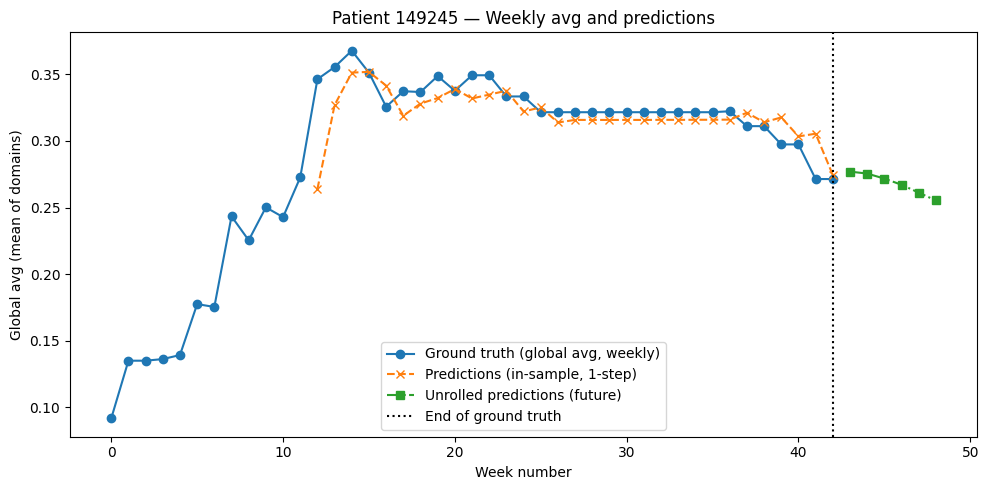

In [41]:
visualize_patient_weekly_trajectory(
    config=CONFIG,
    model=model,
    weekly_df=filtered_weekly_df,
    prescriptor=prescriptor,
    cao_mapping=cao_mapping,
    patient_to_index=patient_to_index,   # required if embeddings enabled
    patient_id=pid,                     # or specify a patient id
)

In [42]:
# get actions prescribed during the rollout
print("Prescribed actions during rollout:")
action_cols = cao_mapping["actions"]
patient_actions_df = pred_df[action_cols]
print(patient_actions_df)

Prescribed actions during rollout:
   domain_1_freq  domain_2_freq  domain_3_freq  domain_4_freq  domain_5_freq  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            0.0            0.0            0.0   

   domain_6_freq  domain_7_freq  domain_8_freq  domain_9_freq  domain_10_freq  \
0            0.0            0.0            0.0            0.0             0.0   
1            0.0            0.0            0.0            0.0             0.0   
2            0.0            0.0            0.0            0.0             0.0   
3            0.0            0.0            0.0            0.0             0.0   